In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Load the data
train = pd.read_csv("Train_Data.csv")
test = pd.read_csv("Test_Data.csv")  



In [3]:
train.head()

,SEQN,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,73564.0,61.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,Adult
1,73568.0,26.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85,Adult
2,73576.0,16.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14,Adult
3,73577.0,32.0,1.0,2.0,28.9,104.0,NaN,84.0,16.15,Adult
4,73580.0,38.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92,Adult


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1966 entries, 0 to 1965
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       1954 non-null   float64
 1   RIDAGEYR   1957 non-null   float64
 2   RIAGENDR   1948 non-null   float64
 3   PAQ605     1953 non-null   float64
 4   BMXBMI     1948 non-null   float64
 5   LBXGLU     1953 non-null   float64
 6   DIQ010     1948 non-null   float64
 7   LBXGLT     1955 non-null   float64
 8   LBXIN      1957 non-null   float64
 9   age_group  1952 non-null   object 
dtypes: float64(9), object(1)
memory usage: 153.7+ KB


In [5]:
# There seems to be some missing valeues in the dataset
train.isnull().sum()

SEQN         12
RIDAGEYR      9
RIAGENDR     18
PAQ605       13
BMXBMI       18
LBXGLU       13
DIQ010       18
LBXGLT       11
LBXIN         9
age_group    14
dtype: int64

In [6]:
# Perform column-wise analysis
column_analysis = []

for column in train.columns:
    column_info = {
        'Column Name': column,
        'Data Type': train[column].dtype,
        'Unique Values': train[column].nunique(),
        'Missing Values': train[column].isnull().sum(),
        # 'Sample Values': train[column].dropna().unique()[:3] if train[column].nunique() > 3 else train[column].dropna().unique()
    }
    column_analysis.append(column_info)

column_analysis_df = pd.DataFrame(column_analysis)
column_analysis_df

,Column Name,Data Type,Unique Values,Missing Values
0,SEQN,float64,1954,12
1,RIDAGEYR,float64,69,9
2,RIAGENDR,float64,2,18
3,PAQ605,float64,3,13
4,BMXBMI,float64,332,18
5,LBXGLU,float64,95,13
6,DIQ010,float64,3,18
7,LBXGLT,float64,224,11
8,LBXIN,float64,1292,9
9,age_group,object,2,14


##### Points to notice
1. The missing values are present in the all of the columns, we dont require SEQN column for this, so we can drop it.
2. We can drop the rows for which the age_group is not present, as we are only interested in predicting the age group.
3.  For the rest of the columns, we can impute the missing values with the median of the column.

In [7]:
# Drop rows with missing target values
train = train.dropna(subset=['age_group'])

# Now map the target to 0 and 1
train['age_group'] = train['age_group'].map({'Adult': 0, 'Senior': 1})

# Drop SEQN (ID column)
X = train.drop(columns=['SEQN', 'age_group'])
y = train['age_group']
X_test = test.drop(columns=['SEQN'])

# Handle missing values using median imputation
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test)

# Scaling features (optional, mostly for XGBoost and LightGBM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# -----------------------------#
# 1. Random Forest
# -----------------------------#
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_val_preds = rf.predict(X_val)
rf_f1 = f1_score(y_val, rf_val_preds)
print("Random Forest F1 Score:", rf_f1)



Random Forest F1 Score: 1.0


Random Forest F1 Score: 1.0


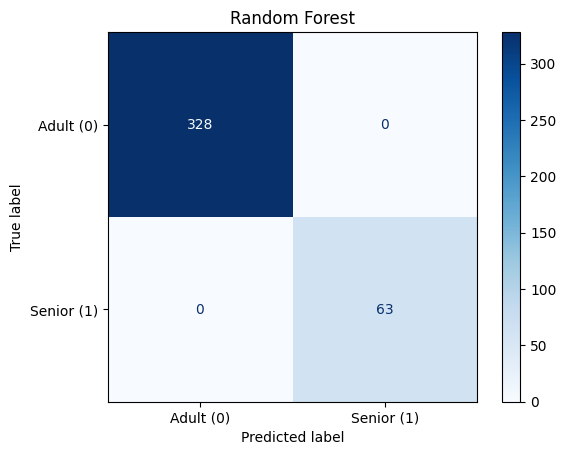

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Adult (0)", "Senior (1)"])
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()


# Random Forest
rf_val_preds = rf.predict(X_val)
print("Random Forest F1 Score:", f1_score(y_val, rf_val_preds))
plot_confusion(y_val, rf_val_preds, title="Random Forest")

c:\Users\arjun\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:05:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost F1 Score: 1.0


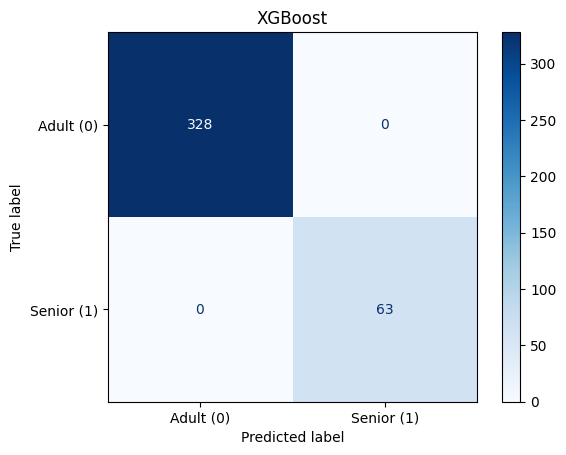

In [9]:
# -----------------------------#
# 2. XGBoost
# -----------------------------#
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_val_preds = xgb.predict(X_val)
xgb_f1 = f1_score(y_val, xgb_val_preds)
print("XGBoost F1 Score:", xgb_f1)


# XGBoost confusion matrix
plot_confusion(y_val, xgb_val_preds, title="XGBoost")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define parameter distributions for Random Forest
rf_param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': [None] + list(np.arange(5, 50, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

# Random Forest with RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,  # 5-fold cross-validation
    scoring='f1',
    random_state=42,
    n_jobs=-1  # Use all available cores
)

rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_
rf_val_preds = best_rf.predict(X_val)
rf_f1 = f1_score(y_val, rf_val_preds)
print("Tuned Random Forest F1 Score:", rf_f1)
plot_confusion(y_val, rf_val_preds, title="Tuned Random Forest")



In [ ]:
# Define parameter distributions for XGBoost
xgb_param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 30),
    'learning_rate': np.arange(0.01, 0.3, 0.05),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1)
}

# XGBoost with RandomizedSearchCV
xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,  # 5-fold cross-validation
    scoring='f1',
    random_state=42,
    n_jobs=-1  # Use all available cores
)

xgb_random.fit(X_train, y_train)
best_xgb = xgb_random.best_estimator_
xgb_val_preds = best_xgb.predict(X_val)
xgb_f1 = f1_score(y_val, xgb_val_preds)
print("Tuned XGBoost F1 Score:", xgb_f1)
plot_confusion(y_val, xgb_val_preds, title="Tuned XGBoost")

In [ ]:
# Determine the best model based on F1 score
best_model = best_xgb if xgb_f1 > rf_f1 else best_rf

# Make predictions using the best model
final_preds = best_model.predict(X_test_scaled)

# Prepare submission
submission = pd.DataFrame({
    'SEQN': test['SEQN'],  # Include SEQN to match predictions with original test data
    'age_group': final_preds  # Predictions are already 0 or 1
})

# Save to CSV
submission.to_csv("submission2.csv", index=False)
print("submission2.csv saved.")
